In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
# make a fix file size
fixed_size  = tuple((500,500))

#train path and test path
base_dir = r"D:\plant disease detection\New Plant Diseases Dataset(Augmented)"
train_path = os.path.join(base_dir,"train")
test_path = os.path.join(base_dir,"valid")

# no of trees for Random Forests
num_tree = 100

# bins for histograms 
bins = 8

# train_test_split size
test_size = 0.10

# seed for reproducing same result 
seed = 9 

In [3]:
# features description -1:  Hu Moments

def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [4]:
# feature-descriptor -2 Haralick Texture 

def fd_haralick(image):
    # conver the image to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # Ccompute the haralick texture fetature ve tor 
    haralic = mahotas.features.haralick(gray).mean(axis=0)
    return haralic

In [5]:
# feature-description -3 Color Histogram

def fd_histogram(image, mask=None):
    # conver the image to HSV colors-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #COPUTE THE COLOR HISTPGRAM
    hist  = cv2.calcHist([image],[0,1,2],None,[bins,bins,bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist,hist)
    # return the histog....
    return hist.flatten()

In [6]:
# get the training data labels 
train_labels = os.listdir(train_path)

# sort the training labesl 
train_labels.sort()
print(train_labels)

# empty list to hold feature vectors and labels 
global_features = []
labels = []

i, j = 0, 0 
k = 0


['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [7]:
plants = []
NumberOfDiseases = 0
for plant in train_labels:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [8]:
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Apple', 'Blueberry', 'Cherry_(including_sour)', 'Corn_(maize)', 'Grape', 'Orange', 'Peach', 'Pepper,_bell', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']


In [9]:
# number of unique plants
print("Number of plants: {}".format(len(plants)))

Number of plants: 14


In [10]:
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 26


So we have images of leaves of 14 plants and while excluding healthy leaves, we have 26 types of images that show a particular disease in a particular plant.

In [11]:
import pandas as pd

# Number of images for each disease
nums = {}
for disease in train_labels:
    nums[disease] = len(os.listdir(train_path + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Apple___Apple_scab,2016
Apple___Black_rot,1987
Apple___Cedar_apple_rust,1760
Apple___healthy,2008
Blueberry___healthy,1816
Cherry_(including_sour)___Powdery_mildew,1683
Cherry_(including_sour)___healthy,1826
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,1642
Corn_(maize)___Common_rust_,1907
Corn_(maize)___Northern_Leaf_Blight,1908


Text(0.5, 1.0, 'Images per each class of plant disease')

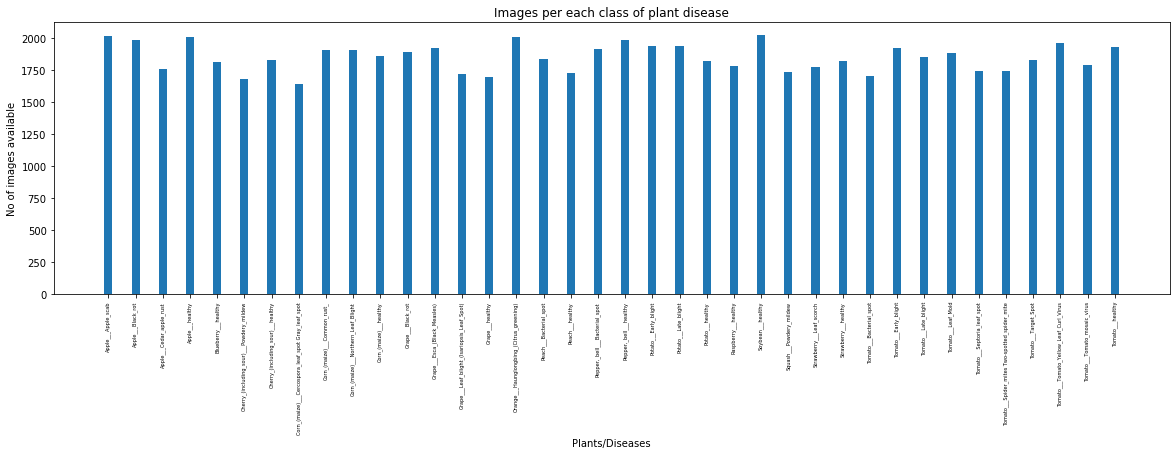

In [12]:
# plotting number of images available for each disease
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, train_labels, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

In [13]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 70295 images for training


In [20]:
# ittirate the folder to get the image label name

get_ipython().run_line_magic('time', '')
# lop over the training data sub folder 

for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    k = 1
    # loop over the images in each sub-folder
        
    for file in os.listdir(dir):

        file = dir + "/" + os.fsdecode(file)
       
        # read the image and resize it to a fixed-size
        image = cv2.imread(file) 
        
        if image is not None:
            image = cv2.resize(image,fixed_size)
            fv_hu_moments = fd_hu_moments(image)
            fv_haralick   = fd_haralick(image)
            fv_histogram  = fd_histogram(image)
        #else:
            #print("image not loaded")
                
        #image = cv2.imread(file)        
        #image = cv2.resize(image,fixed_size)

        # Concatenate global features
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

        i += 1
        k += 1
    print("[STATUS] processed folder: {}".format(current_label))
    j += 1

print("[STATUS] completed Global Feature Extraction...")

Wall time: 0 ns
[STATUS] processed folder: Apple___Apple_scab
[STATUS] processed folder: Apple___Black_rot
[STATUS] processed folder: Apple___Cedar_apple_rust
[STATUS] processed folder: Apple___healthy
[STATUS] processed folder: Blueberry___healthy
[STATUS] processed folder: Cherry_(including_sour)___Powdery_mildew
[STATUS] processed folder: Cherry_(including_sour)___healthy
[STATUS] processed folder: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
[STATUS] processed folder: Corn_(maize)___Common_rust_
[STATUS] processed folder: Corn_(maize)___Northern_Leaf_Blight
[STATUS] processed folder: Corn_(maize)___healthy
[STATUS] processed folder: Grape___Black_rot
[STATUS] processed folder: Grape___Esca_(Black_Measles)
[STATUS] processed folder: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
[STATUS] processed folder: Grape___healthy
[STATUS] processed folder: Orange___Haunglongbing_(Citrus_greening)
[STATUS] processed folder: Peach___Bacterial_spot
[STATUS] processed folder: Peach___healthy
[

In [22]:
get_ipython().run_line_magic('time', '')
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print("[STATUS] training labels encoded...{}")
# normalize the feature vector in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

# save the feature vector using HDF5
h5f_data = h5py.File('data.h5', 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File('labels.h5', 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

Wall time: 0 ns
[STATUS] feature vector size (71989, 532)
[STATUS] training Labels (71989,)
[STATUS] training labels encoded...{}
[STATUS] feature vector normalized...
[STATUS] target labels: [ 0  0  0 ... 37 37 37]
[STATUS] target labels shape: (71989,)
[STATUS] end of training..


In [23]:
# import the feature vector and trained labels

h5f_data = h5py.File('data.h5', 'r')
h5f_label = h5py.File('labels.h5', 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string) 

In [24]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)


In [30]:
# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=100)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

#print(clf.fit(trainDataGlobal, trainLabelsGlobal))

clf_pred = clf.predict(trainDataGlobal)
#clf_pred = clf.predict(global_feature.reshape(1,-1))[0]
#print(confusion_matrix(trainLabelsGlobal,clf_pred))

#print(clf.predict(trainDataGlobal))

#print(clf.predict(global_feature.reshape(1,-1))[0])

In [33]:
from sklearn.metrics import classification_report

report_dict = classification_report(trainLabelsGlobal, clf_pred, output_dict=True)

In [35]:
pd.DataFrame(report_dict)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
support,3336.0,1801.0,1561.0,1807.0,1637.0,1501.0,1639.0,1494.0,1722.0,1695.0,...,1692.0,1574.0,1570.0,1632.0,1755.0,1585.0,1737.0,1.0,64790.0,64790.0


In [68]:
# # loop through the test images
# #for file in glob.glob(test_path + "/*.jpg"):
# for training_name in train_labels:
#     # join the training data path and each species training folder
#     dir = os.path.join(test_path, training_name)

#     # get the current training label
#     current_label = training_name

#     k = 1
#     # loop over the images in each sub-folder
        
#     for file in os.listdir(dir):

#         file = dir + "/" + os.fsdecode(file)
       
#         # read the image and resize it to a fixed-size
#         image = cv2.imread(file) 
        
#         if image is not None:
#             image = cv2.resize(image,fixed_size)
#             fv_hu_moments = fd_hu_moments(image)
#             fv_haralick   = fd_haralick(image)
#             fv_histogram  = fd_histogram(image)
#         #else:
#             #print("image not loaded")
                
#         #image = cv2.imread(file)        
#         #image = cv2.resize(image,fixed_size)

#         # Concatenate global features
#         global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

#         # predict label of test image
#         prediction = clf.predict(global_feature.reshape(1,-1))[0]

#         # show predicted label on image
#         cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

#         # display the output image
#         plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#         plt.show()

# print("[STATUS] completed Testing ...")

In [54]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(trainLabelsGlobal,clf_pred))

[[3336    0    0 ...    0    0    0]
 [   0 1801    0 ...    0    0    0]
 [   0    0 1561 ...    0    0    0]
 ...
 [   0    0    0 ... 1755    0    0]
 [   0    0    0 ...    0 1585    0]
 [   0    0    0 ...    0    0 1737]]


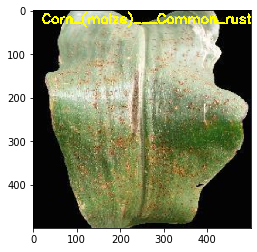

In [67]:
image = cv2.imread(r"D:\plant disease detection\test\test\CornCommonRust2.JPG")

# resize the image
image = cv2.resize(image, fixed_size)

# Global Feature extraction
fv_hu_moments = fd_hu_moments(image)
fv_haralick   = fd_haralick(image)
fv_histogram  = fd_histogram(image)

# Concatenate global features
global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

# predict label of test image
prediction = clf.predict(global_feature.reshape(1,-1))[0]

# show predicted label on image
cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

# display the output image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()